# Welcome to my first NLP Competition! This is my first notebook attempt for the NLP with Disaster Tweets (Kaggle) Competition!

## Step 1: pip install dependencies

In [2]:
# %pip install pandas numpy tensorflow transformers scikit-learn matplotlib

# #python.exe -m pip install --upgrade pip

## Step 2: Exploring and Understanding the data

### Loading Data

In [4]:
import pandas as pd

# Load the training data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Display the first few rows of the training data
print(train_data.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


### Data Cleaning

I had a hard choice of whether or not to delete hashtags, but after inspecting the data, I saw that there were so many hashtags and hashtags are a crucial part of tweets so I decided that I want to keep them and then do the extra work of preprecessing them later on when I preprocess the data.

I might go and remove hashtags in the future, to see how it affects the performance. So, if you see that I decided to remove the hashtags, then now you know why!

In [5]:
import re # Regular Expression

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'[^\w\s#]', '', text)  # Remove punctuation except hashtags
    text = text.lower()                  # Convert to lowercase
    return text

train_data['clean_text'] = train_data['text'].apply(clean_text) # Apply the data cleaning process to training data
test_data['clean_text'] = test_data['text'].apply(clean_text)# Apply the data cleaning process to testing data

# Display the first few rows of the cleaned data
print(train_data[['text', 'clean_text']].head())


                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0  our deeds are the reason of this #earthquake m...  
1              forest fire near la ronge sask canada  
2  all residents asked to shelter in place are be...  
3   people receive #wildfires evacuation orders i...  
4  just got sent this photo from ruby #alaska as ...  


## Step 3: Preprocessing and Tokenization

### Tokenization from bert-base-uncased

In [6]:
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example raw tweet
tweet = "There is a disaster happening"

# Tokenize the tweet
tokenized_tweet = tokenizer.encode(tweet, add_special_tokens=True)
print("Tokenized Tweet:", tokenized_tweet)

# Tokenize the clean text including hashtags
train_data['tokens'] = train_data['clean_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
test_data['tokens'] = test_data['clean_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))


# Display the first few tokenized texts
print(train_data[['clean_text', 'tokens']].head())


Tokenized Tweet: [101, 2045, 2003, 1037, 7071, 6230, 102]
                                          clean_text  \
0  our deeds are the reason of this #earthquake m...   
1              forest fire near la ronge sask canada   
2  all residents asked to shelter in place are be...   
3   people receive #wildfires evacuation orders i...   
4  just got sent this photo from ruby #alaska as ...   

                                              tokens  
0  [101, 2256, 15616, 2024, 1996, 3114, 1997, 202...  
1  [101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...  
2  [101, 2035, 3901, 2356, 2000, 7713, 1999, 2173...  
3  [101, 2111, 4374, 1001, 3748, 26332, 13982, 44...  
4  [101, 2074, 2288, 2741, 2023, 6302, 2013, 1009...  


### Analyzing the length of tokens to find the optimal maximum length for sequences

Based on the results from this, we saw that the maximum sequence length (a sequence in this context is a single tweet) was around 40, and so we will pick a multiple of 2 for better computational performance. 

So, I decided on 64!

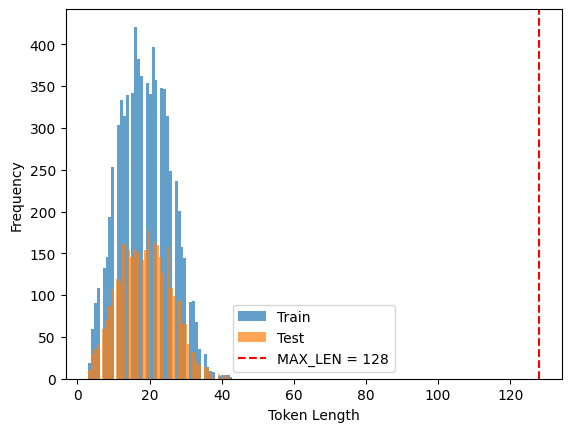

Train token length statistics:
count    7613.000000
mean       18.689741
std         7.073642
min         3.000000
25%        13.000000
50%        19.000000
75%        24.000000
max        43.000000
Name: token_length, dtype: float64

Test token length statistics:
count    3263.000000
mean       18.774441
std         7.170217
min         3.000000
25%        13.000000
50%        19.000000
75%        24.000000
max        42.000000
Name: token_length, dtype: float64


In [7]:
import matplotlib.pyplot as plt

# Tokenize the clean text without padding to get the length of each tweet
train_data['token_length'] = train_data['clean_text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))
test_data['token_length'] = test_data['clean_text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

# Plot the distribution of token lengths
plt.hist(train_data['token_length'], bins=50, alpha=0.7, label='Train')
plt.hist(test_data['token_length'], bins=50, alpha=0.7, label='Test')
plt.axvline(x=128, color='r', linestyle='--', label='MAX_LEN = 128')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Display some statistics
print("Train token length statistics:")
print(train_data['token_length'].describe())

print("\nTest token length statistics:")
print(test_data['token_length'].describe())


### Padding and Truncation

In [8]:
# Define the custom maximum length for the sequences based on analysis
MAX_LEN = 64

# Pad the token sequences and truncate longer sequences
padded_train_tokens = pad_sequences(train_data['tokens'].tolist(), maxlen=MAX_LEN, padding='post', truncating='post')
padded_test_tokens = pad_sequences(test_data['tokens'].tolist(), maxlen=MAX_LEN, padding='post', truncating='post')

# Convert the 2D arrays to lists of lists
train_data['padded_tokens'] = list(padded_train_tokens)
test_data['padded_tokens'] = list(padded_test_tokens)

# Display the first few tokenized and padded sequences
print(train_data[['tokens', 'padded_tokens']].head())

                                              tokens  \
0  [101, 2256, 15616, 2024, 1996, 3114, 1997, 202...   
1  [101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...   
2  [101, 2035, 3901, 2356, 2000, 7713, 1999, 2173...   
3  [101, 2111, 4374, 1001, 3748, 26332, 13982, 44...   
4  [101, 2074, 2288, 2741, 2023, 6302, 2013, 1009...   

                                       padded_tokens  
0  [101, 2256, 15616, 2024, 1996, 3114, 1997, 202...  
1  [101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...  
2  [101, 2035, 3901, 2356, 2000, 7713, 1999, 2173...  
3  [101, 2111, 4374, 1001, 3748, 26332, 13982, 44...  
4  [101, 2074, 2288, 2741, 2023, 6302, 2013, 1009...  


## Step 4: Building a model!!!

### Picking a Model Architecture

I am going to pick BERT but I might play around with other pretrained models later. 

This is an example of transfer learning, where I am taking a pretrained model (ex. BERT) and then training it on my specific data. No need to re-invent the wheel, especially since it will take long time to make a model from scratch and I might not get great results back since my training data size is not very good. The BERT model is training on SO MUCH data, so it's already very smart.

I am using the BERT model and by doing import TFBertForSequenceClassification, I am using the model that adds a classification head to the BERT base model. Adding a layer to a pre-trained model is a crucial part of transfer learning, and by training the model on my data, I will be setting the weights of the new head layer of the model, which is where it learns about disaster tweets and how to classify them!

In [9]:
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) # num_labels = 2 since this is a binary classification

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Compiling the Model

In [10]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

## Step 5: Training the Model

### Prepare the Data for Training

In [11]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_val, y_train, y_val = train_test_split(train_data['padded_tokens'], train_data['target'], test_size=0.1, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train.tolist(), y_train.tolist())).shuffle(len(X_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.tolist(), y_val.tolist())).batch(32)

### Train the model


In [12]:
history = model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3


AttributeError: in user code:

    File "c:\Users\Micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Micha\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_tf_utils.py", line 1588, in compute_loss  *
        return super().compute_loss(*args, **kwargs)
    File "c:\Users\Micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss  **
        return self.compiled_loss(
    File "c:\Users\Micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\compile_utils.py", line 275, in __call__
        y_t, y_p, sw = match_dtype_and_rank(y_t, y_p, sw)
    File "c:\Users\Micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\compile_utils.py", line 854, in match_dtype_and_rank
        if (y_t.dtype.is_floating and y_p.dtype.is_floating) or (

    AttributeError: 'NoneType' object has no attribute 'dtype'


## Step 6: Evaluating and Submitting the Results

### Predict on the test set

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_data['padded_tokens'].tolist()).batch(32)
predictions = model.predict(test_dataset).logits
predictions = tf.nn.softmax(predictions, axis=1)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

### Prepare the Submission File:

In [ ]:
submission = pd.DataFrame({'id': test_data['id'], 'target': predicted_labels})
submission.to_csv('../data/submission.csv', index=False)

## Step 7: Iterating and Improving

Hyperparameter Tuning:
- Experiment with different hyperparameters such as learning rate, batch size, and the number of epochs to improve the model’s performance.

Data Augmentation:
- Consider using data augmentation techniques to increase the diversity of your training data.

Model Ensembles:
- Combine the predictions from multiple models to improve overall performance.